In [1]:
import pandas as pd
from fbprophet import Prophet
from scipy.optimize import curve_fit
from functools import partial
import us
import numpy as np
from matplotlib import pyplot

confirmed_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

## Prophet Predictor

Prophet is a forecasting procedure implemented in R and Python. It is fast and provides completely automated forecasts that can be tuned by hand by data scientists and analysts.

https://facebook.github.io/prophet/

In [2]:
def prophet_predictor(dates, values, predict_length=3):
    df = pd.DataFrame({"ds": dates, "y": values})
    m = Prophet(
        changepoint_prior_scale=0.2,
        changepoint_range=0.98,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=True,
        seasonality_mode='additive')
    m.fit(df)
    
    future = m.make_future_dataframe(periods=predict_length)
    forecast = m.predict(future)
    
    return forecast[-predict_length:][['yhat_lower', 'yhat_upper']].mean(axis=1).to_numpy()

## Sigmoid Predictor

For this algorithm, we take advantage of the fact that the pattern we are trying to predict can already be observed elsewhere. First, a Sigmoid curve is fitted to an existing data set that has reached maturity. Then, the Sigmoid is scaled and shifted to fit a new data set that is presented to it.

In [3]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def sigmoid_transform(popt, x, x_shift, scale):
    y = scale * (popt[0] / (1 + np.exp(-popt[2]*((x+x_shift)-popt[1])))+popt[3])
    return y

def calc_base_sigmoid(dates, values):
    xdata = list(range(len(dates)))
    p0 = [max(values), np.median(xdata), 1, min(values)]
    popt, pcov = curve_fit(sigmoid, xdata, values, p0, method='dogbox')
    
    ############## DEBUG PLOTS #######################
    # ypred = [sigmoid(val, *popt) for val in xdata]
    # pyplot.figure()
    # pyplot.plot(xdata, values, xdata, ypred)
    ##################################################
    
    return popt

def sigmoid_predictor(dates, values, popt_base, predict_length=3):
    xdata = list(range(len(dates)))
    bnew = np.where(values > 0)[0][0]
    p0 = [bnew, 1]
    sigt = partial(sigmoid_transform, popt_base)
    popt, pcov = curve_fit(sigt, xdata, values, p0, method='dogbox')

    xpred = list(range(len(xdata), len(xdata)+predict_length))
    
    ############## DEBUG PLOTS #######################
    # ypred = [sigt(val, *popt) for val in xpred]
    # pyplot.figure()
    # pyplot.plot(xdata, values, xpred, ypred)
    # pyplot.xlim(left=bnew, right=70)
    ##################################################
    
    return np.array([sigt(val, *popt) for val in xpred])

## Load and Clean the Data

We will be using the data published by Johns Hopkins.

In [4]:
# load the data
confirmed = pd.read_csv(confirmed_csv).drop(['Lat', 'Long'], axis=1)
# clean the data
confirmed = confirmed.rename({'Province/State': 'State', 'Country/Region': 'Country'}, axis='columns')

# convenience indices
all_time = confirmed.columns[5:]
last_week = all_time[-7:]
last_month = all_time[-30:]
us_states = [state.name for state in us.states.STATES]

The earlier data published for the United States was broken down by County rather than State. This needs to be cleaned before the data can be used. It will also be much easier to work with the data if we normalize the location down to a single column. Both of these tasks can be done at once.

In [5]:
def uscounty2state(county):
    try:
        abbv = county.split(', ')[1].strip()
    except IndexError:
        pass
    else:
        if abbv == "D.C.":
            state = us.states.lookup("District of Columbia")
        else:
            state = us.states.lookup(abbv)
        if state:
            return state.name
    return county

def normal_location(country, state):
    if country == 'US':
        state = uscounty2state(state)
    return f'{country}_{state}'

In [6]:
for idx in confirmed.index:
    confirmed.loc[idx, 'State'] = normal_location(confirmed.loc[idx, 'Country'], confirmed.loc[idx, 'State'])
confirmed = confirmed.groupby(['State'], as_index=False).sum().sort_values(by=all_time[-1], ascending=False)
confirmed.head()

,State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
65,China_Hubei,444,444,549,761,1058,1423,3554,3554,4903,...,67786,67790,67794,67798,67799,67800,67800,67800,67800,67800
142,Italy_nan,0,0,0,0,0,0,0,0,0,...,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138
209,Spain_nan,0,0,0,0,0,0,0,0,0,...,5232,6391,7798,9942,11748,13910,17963,20410,25374,28768
124,Germany_nan,0,0,0,0,0,1,4,4,4,...,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873
138,Iran_nan,0,0,0,0,0,0,0,0,0,...,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638


Before we leave here, let's make some helper functions to find Countries and States.

In [7]:
def find_country(df, country):
    return df[df.index.str.contains(f'{country}_')]

def find_state(df, country, state):
    return df.query(f'State == "{country}_{state}"')

## Validate the Models
The goal is to be able to accurately predict three days into the future. We have designed two learning algorithms, one supervised (Sigmoid) and one unsupervised (Prophet). For the top 10 regions, lets evaluate the predictions by removing the last three days worth of data, predicting over the last three days, and then evaluating the error.

In [8]:
def split_train_test(df, test_length=3):
    return df[['State'] + all_time[:-test_length].to_list()]

In [9]:
days_to_predict = 2

all_time_train = all_time[:-days_to_predict]
future = all_time[-days_to_predict:]

hubei = find_state(confirmed, 'China', 'Hubei')
hubei_train = split_train_test(hubei, days_to_predict)

top = confirmed[0:20]
top_train = split_train_test(top, days_to_predict)

First the Sigmoid model needs to be trained using the Hubei data as it is the most advanced. Keep in mind, this means that error calculations for the Sigmoid model's analysis of Hubei are invalid as it has already seen that data.

In [10]:
popt_hubei = calc_base_sigmoid(all_time_train, hubei_train[all_time_train].to_numpy()[0])

Now, let's evaluate both of our models to predict the last three days of activity.

In [11]:
template = {date: [] for date in future}
template.update({'State': []})
prophet_predictions = pd.DataFrame(template)
sigmoid_predictions = pd.DataFrame(template)

In [12]:
for idx in top.index:
    state = top.loc[idx, 'State']
    print(state)
    
    prophet_future = prophet_predictor(all_time_train, top_train.loc[idx, all_time_train].to_numpy(), days_to_predict)
    sigmoid_future = sigmoid_predictor(all_time_train, top_train.loc[idx, all_time_train].to_numpy(), popt_hubei, days_to_predict)
    
    prophet_predictions.loc[idx, 'State'] = state
    prophet_predictions.loc[idx, future] = prophet_future
    sigmoid_predictions.loc[idx, 'State'] = state
    sigmoid_predictions.loc[idx, future] = sigmoid_future

China_Hubei
Italy_nan
Spain_nan
Germany_nan
Iran_nan
France_France
US_New York
Korea, South_nan
Switzerland_nan
United Kingdom_United Kingdom
Netherlands_Netherlands
Belgium_nan
Austria_nan
Norway_nan
US_Washington
Sweden_nan
US_New Jersey
US_California
Portugal_nan
Brazil_nan


And plot the results...

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



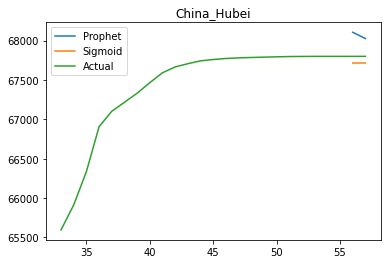

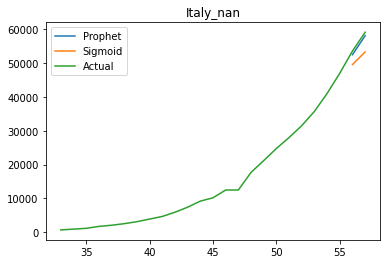

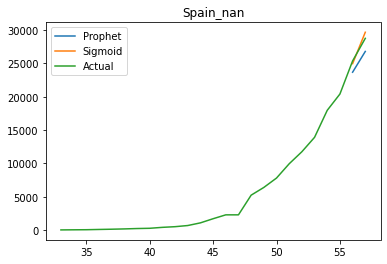

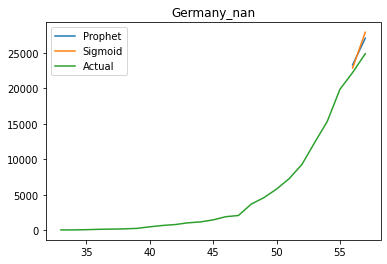

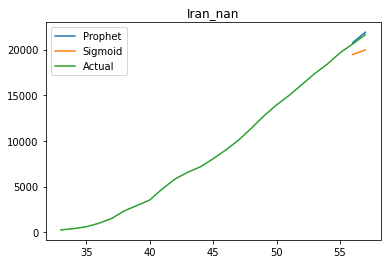

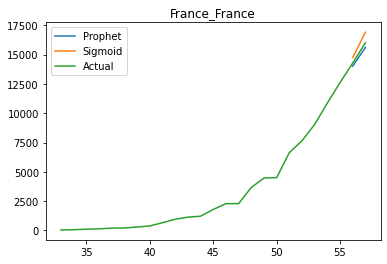

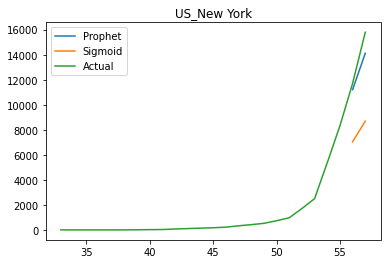

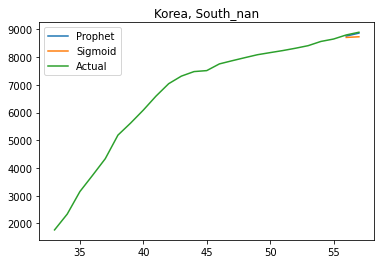

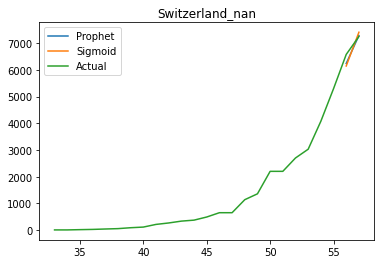

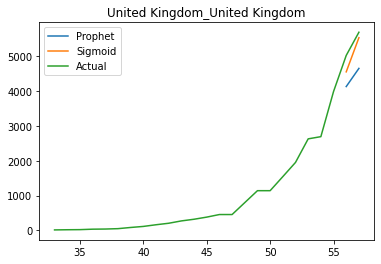

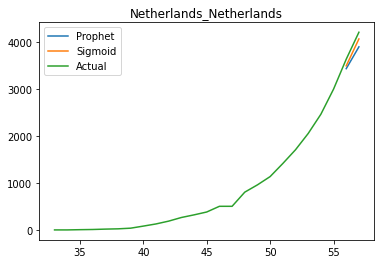

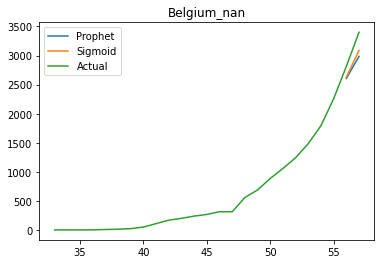

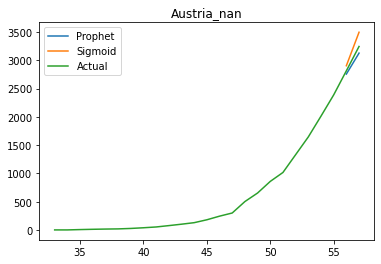

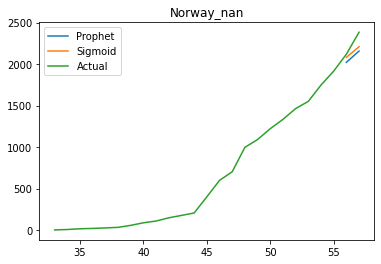

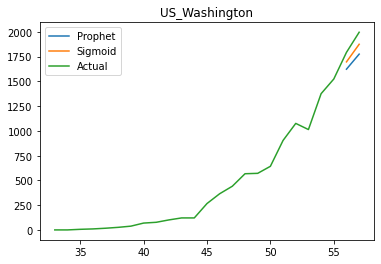

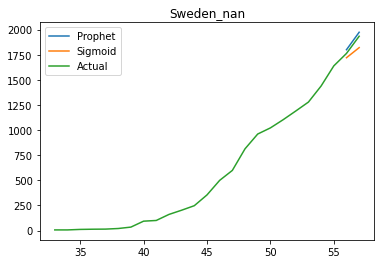

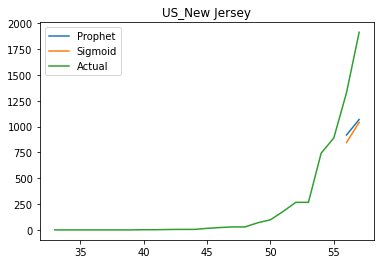

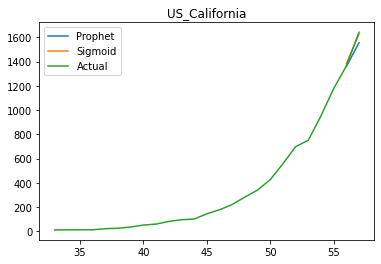

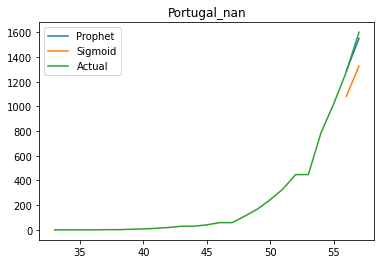

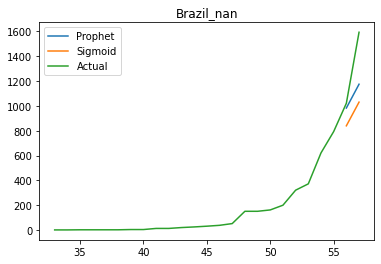

<Figure size 432x288 with 0 Axes>

In [13]:
for idx in top.index:
    state = top.loc[idx, 'State']
    
    x_actual = list(range(len(all_time)))[-25:]
    y_actual = top.loc[idx, all_time][-25:]
    
    x_pred = x_actual[-days_to_predict:]
    y_pred_prophet = prophet_predictions.loc[idx, future]
    y_pred_sigmoid = sigmoid_predictions.loc[idx, future]
    
    pyplot.plot(x_pred, y_pred_prophet, x_pred, y_pred_sigmoid, x_actual, y_actual)
    pyplot.legend(['Prophet', 'Sigmoid', 'Actual'])
    pyplot.title(state)
    pyplot.figure()